# SSR-GAN Model

In [1]:
import torch
from torch import nn
%load_ext line_profiler

class ConvBlock(nn.Module):
    def __init__(self, inc, outc, k, s, p, bn=True, subpix=False):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv1d(inc, outc, kernel_size=k, stride=s, padding=p),
            nn.BatchNorm1d(outc) if bn else nn.Identity(),
            nn.LeakyReLU(0.2)
        )
        self.subpix = subpix
        if subpix:
            self.ps = nn.PixelShuffle(2)

    def forward(self, x):
        if self.subpix:
            x = self.ps(x.unsqueeze(2))
            b, c, h, w = x.shape
            x = x.reshape(b, c * h, w)
        out = self.block(x)
        return out
        
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            ConvBlock(129, 256, 7, 2, 3), # 16x256
            ConvBlock(256, 512, 5, 2, 2), # 8x512
            ConvBlock(512, 512, 3, 2, 1)  # 4x512
        )
        
        self.bottle = ConvBlock(512, 1024, 3, 2, 1) # 2x1024
        
        self.decoder = nn.Sequential(
            ConvBlock(512, 512, 3, 1, 1, subpix=True), # +4x512 skip
            ConvBlock(512, 512, 5, 1, 2, subpix=True), # +8x512 skip
            ConvBlock(512, 256, 7, 1, 3, subpix=True) # +16x256 skip
        )
        
        self.final = nn.Sequential(
            ConvBlock(256, 141, 7, 1, 3, subpix=True),
            ConvBlock(141, 141, 9, 1, 4, bn=False) # тут лрелу в конце!
        )

    def forward(self, x):
        skips = []
        for layer in self.encoder:
            x = layer(x)
            skips.append(x)
        x = self.bottle(x)
        
        for layer in self.decoder:
            x = layer(x)
            x = torch.cat([x, skips.pop()], dim=1)

        out = self.final(x)
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.convs = nn.Sequential(
            ConvBlock(129 + 141, 1024, 7, 2, 3, bn=False),
            ConvBlock(1024, 1024, 5, 2, 2, bn=False),
            ConvBlock(1024, 1024, 3, 2, 1, bn=False),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4 * 1024, 2048),
            nn.LeakyReLU(0.2),
            nn.Linear(2048, 1),
        )
   
    def forward(self, x):
        x = self.convs(x)
        out = self.fc(x)
        return out, torch.sigmoid(out)

## Losses

In [2]:
def reconstruction_loss(true, pred):
    return torch.mean(torch.sqrt(torch.mean((true - pred) ** 2, dim=1) + 1e-18))

def regularization_term(fake_prob, real_prob, fake_logit, real_logit):
    real_grad = torch.autograd.grad(outputs=real_prob, inputs=real_logit,
                                grad_outputs=torch.ones_like(real_prob),
                                retain_graph=True, create_graph=True, only_inputs=True)[0]
    fake_grad = torch.autograd.grad(outputs=fake_prob, inputs=fake_logit,
                                grad_outputs=torch.ones_like(fake_prob),
                                retain_graph=True, create_graph=True, only_inputs=True)[0]
    
    ep = torch.mean(torch.square(1 - real_prob) * torch.square(torch.norm(real_grad)))
    eq = torch.mean(torch.square(fake_prob) * torch.square(torch.norm(fake_grad)))
    return ep + eq

def disc_loss(fake_prob, real_prob):
    return torch.mean(torch.log(real_prob)) + torch.mean(torch.log(1 - fake_prob))

def gen_loss(fake_prob):
    return torch.mean(torch.log(fake_prob))

def segsnr(true, pred):
    return torch.mean(10 * torch.log(torch.div(
                torch.mean(torch.square(true), 2), 
                torch.mean(torch.square(true - pred), 2))), 1)

### Test

In [3]:
G = Generator()
D = Discriminator()
optimizerG = torch.optim.Adam(G.parameters(), lr=1e-4)
optimizerD = torch.optim.RMSprop(D.parameters(), lr=1e-4)
gamma = 2
lambd = 0.5
batch = 64

In [4]:
real_lf = torch.rand(batch, 129, 32)
real_hf = torch.rand(batch, 141, 32)
fake_hf = G(real_lf)
fake_full = torch.cat([real_lf, fake_hf], dim=1)
real_full = torch.cat([real_lf, real_hf], dim=1)
fake_logit, fake_prob = D(fake_full)
real_logit, real_prob = D(real_full)

In [5]:
lossD = disc_loss(fake_prob, real_prob) + 0.5 * gamma * regularization_term(fake_prob, real_prob, fake_logit, real_logit)
lossG = gen_loss(fake_prob) + lambd * reconstruction_loss(real_full, fake_full)
lossD.backward(retain_graph=True)
lossG.backward()

In [6]:
lossD.item(), lossG.item()

(0.6129306554794312, -0.5019345879554749)

## Preprocessing and SSR-System

In [7]:
from scipy.io import wavfile
from pesq import pesq

import torchaudio
import matplotlib.pyplot as plt

import numpy as np
import resampy
import IPython

rate, ref = wavfile.read("5_gt.wav")
rate, deg = wavfile.read("5_gen.wav")
wavfile.write('5_gt_2.wav', rate, ref)
print(rate)
print(pesq(rate, ref, deg, 'wb'))

16000
1.6282330751419067


In [8]:
# 32 ms window size, 8 ms hop size
# the log and power operations to obtain LPS
# chopped up the utterances into T=32 timesteps


#######DONE######
# For our method, we applied the band-limited sinc interpolation method described in [34] 
# to the high-resolution signal and obtained the downsampled signal
# We applied a low-pass filter and downsampled the highresolution signals 
# to obtain their parallel low-resolution signals
# for training and testing

################TODO
# to create an artificial phase by flipping
# the narrowband phase and reverting the sign. 
# For the 2x superresolution version, we concatenate this flipped phase with the
# narrowband phase to obtain an artificial phase XˆP of the entire wideband signal. 
# In this work, we simply flipped the phase of the lowresolution 
# signal as the phase of the high-frequency range of the SSR output. 

# To improve our results, we considered Griffin-Lim algorithm 

# Finally, inverse STFT is applied to the complex spectrogram
# calculated from the estimated wideband LPS XSR and artificial phase Xˆ
# P , and the time domain signal yˆ is reconstructed
# using the overlap-add method.

## STFT / Spectrogram / mag+phase

In [9]:
hann = False # False then is "window of ones"
power = 2.0 # None (spec is just stft) or 1.0 (spec is magnitude) or 2.0 (spec is squared magnitude)
win_length = 32
hop_length = 8
T = 32
win = lambda x: torch.ones(x) if not hann else torch.hann_window(x)

def lps(x):
    # log power spectrogram
    if power is None or x.ndim == 4:
        return torch.log(torch.square(x[...,0]))
    elif power == 1:
        return torch.log(torch.square(x))
    elif power == 2:
        return torch.log(x)


spec_kwargs = dict(n_fft=(141 + 129) * 2 - 1, win_length=win_length, hop_length=hop_length, normalized=False)
to_spec = torchaudio.transforms.Spectrogram(**spec_kwargs, power=power, window_fn=win)

ref_ = torch.tensor(ref.copy())

spec = to_spec(ref_)
stft = torch.stft(ref_, **spec_kwargs, window=win(spec_kwargs['win_length']))
m, p = torchaudio.functional.magphase(stft)
stft.shape, spec.shape, m.shape, p.shape

(torch.Size([270, 2048, 2]),
 torch.Size([270, 2048]),
 torch.Size([270, 2048]),
 torch.Size([270, 2048]))

In [10]:
def mag_from_spec(spec):
    if power is not None:
        return torch.pow(spec, 1 / power)
    else:
        return torchaudio.functional.complex_norm(spec)

In [11]:
(mag_from_spec(spec) == m).all().item()

True

## Downsampling with the band-limited sinc interpolation

In [12]:
rate_div = 2
ref_small = resampy.resample(ref, rate, rate // rate_div, axis=0, filter='sinc_window', num_zeros=64)
ref.shape, ref_small.shape

((16384,), (8192,))

In [13]:
IPython.display.Audio(ref, rate=rate)

In [14]:
IPython.display.Audio(ref_small, rate=rate // rate_div)

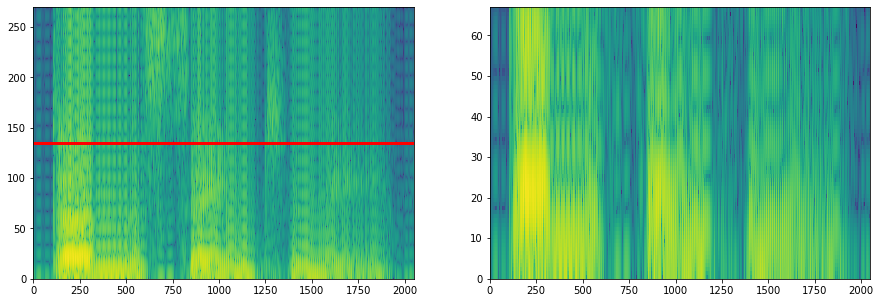

In [15]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.pcolormesh(lps(to_spec(ref_)))
plt.hlines(spec.shape[0] // rate_div, 0, spec.shape[1], colors='r', linewidth=3)
plt.subplot(122)
plt.pcolormesh(lps(spec[:spec.shape[0]//4]))
plt.show()

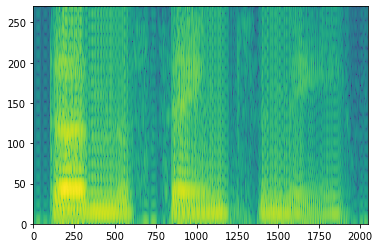

In [16]:
spec_small_kwargs = dict(n_fft=(141 + 129) * 2 - 1, win_length=32, hop_length=4, normalized=False)
to_spec_small = torchaudio.transforms.Spectrogram(**spec_small_kwargs, power=power, window_fn=win)
spec_small = to_spec_small(torch.tensor(ref_small.copy()))
plt.pcolormesh(lps(spec_small))
plt.show()

## STFT from Mag and Phase

In [17]:
def from_mag_phase(m, p):
    return torch.cat([(m * torch.cos(p)).unsqueeze(-1), 
                      (m * torch.sin(p)).unsqueeze(-1)], -1)

In [18]:
np.isclose(from_mag_phase(m, p), stft).mean()

0.9990080656828704

## Wave from STFT 

### istft

In [19]:
ref_pred = torchaudio.functional.istft(from_mag_phase(m, p), **spec_kwargs)
np.isclose(ref_pred, ref[:ref_pred.shape[0]]).mean()

1.0

In [20]:
IPython.display.Audio(ref_pred, rate=rate)

### Griffin-Lim (from spectrogram)

In [21]:
hann = False # False then is "window of ones"
to_spec = torchaudio.transforms.Spectrogram(**spec_kwargs, power=power, window_fn=win)
to_wave = torchaudio.transforms.GriffinLim(**spec_kwargs)

In [22]:
IPython.display.Audio(to_wave(to_spec(ref_) ** (1 / power)), rate=rate)

# Train заLoop

In [23]:
######### TODO
# The input and output LPSs were normalized to have zero mean and unit variance; We calculated these
# statistics from the training data and applied them during inference.

In [24]:
def full_lps(wave):
    spec = torchaudio.transforms.Spectrogram(n_fft=((141 + 129) * 2) - 1, 
                                      win_length=win_length, hop_length=hop_length, window_fn=win, 
                                      power=power, normalized=False)(wave)
    return lps(spec)[...,:T]

def lowres_lps(wave, rate_div):
    wave = resampy.resample(wave.cpu().detach().numpy(),
                            rate, rate // rate_div, axis=-1, filter='sinc_window', num_zeros=64)
    wave = torch.tensor(wave)
    spec = torchaudio.transforms.Spectrogram(n_fft=(129 * 2) - 1, pad=3,
                                      win_length=win_length, hop_length=hop_length // rate_div, window_fn=win, 
                                      power=power, normalized=False)(wave)
    return lps(spec)[...,:T]


In [25]:
import sys
sys.path += ["../"]
from segan_pytorch.segan.datasets import se_dataset

batch_size = 256
slice_size = 270
gamma = 2
lambd = 0.5
task = 'sr'
rate_div = 2


hann = False # False - "window of ones"
power = 2.0 # None (spec is just stft) or 1.0 (spec is magnitude) or 2.0 (spec is squared magnitude)
win_length = 32
hop_length = 8
T = 32
win = lambda x: torch.ones(x) if not hann else torch.hann_window(x)


num_epochs = 3

/home/sorain/.conda/envs/sorain_tf/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/home/sorain/.conda/envs/sorain_tf/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [26]:
! rm -rf data

In [27]:
cache_dir = './data'
clean_dir = '/home/sorain/my_wham/train/clean'
noisy_dir = '/home/sorain/my_wham/train/noisy'

dataset = se_dataset.SEDataset(clean_dir, noisy_dir, 0.95, cache_dir=cache_dir, slice_size=slice_size, max_samples=10)
dloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

Creating train split out of data in /home/sorain/my_wham/train/clean
Found 20001 clean names and 20001 noisy names


In [28]:
len(dloader)

15

In [29]:
G = Generator()
D = Discriminator()
optimizerG = torch.optim.Adam(G.parameters(), lr=1e-4)
optimizerD = torch.optim.RMSprop(D.parameters(), lr=1e-4)

In [30]:
from tqdm.notebook import tqdm
torch.autograd.set_detect_anomaly(True)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device('cpu')

G.to(device)
D.to(device)

g_loss = []
d_loss = []

for epoch in range(num_epochs):
    if epoch == (num_epochs // 3):
        optimizerD.param_groups[0]['lr'] = optimizerD.param_groups[0]['lr'] / 10
        optimizerG.param_groups[0]['lr'] = optimizerG.param_groups[0]['lr'] / 10
    
    for bidx, batch in tqdm(enumerate(dloader, 1), total=len(dloader)):
        uttname, clean, noisy, slice_idx = batch
        # clean, noisy = clean.to(device), noisy.to(device)
        clean, noisy = clean.to(device), noisy.to(device)
        if task == 'sr':
#             real_full = torch.randn(2048, 270, 32)#
            real_full = full_lps(clean).to(device)
            lf = lowres_lps(clean, rate_div).to(device)
        else:
#             raise NotImplementedError('denoising task is not implemented yet')
            real_full = full_lps(clean).detach().clone().to(device)
            lf = full_lps(noisy)[:,:129,:].detach().clone().to(device)
#         lf = lf.to(device)
        fake_hf = G(lf)
        fake_hf = fake_hf.to(device)
        fake_full = torch.cat([lf, fake_hf], 1)
#         real_full = real_full
        if epoch >= (num_epochs // 3):
            fake_logit, fake_prob = D(fake_full)
            real_logit, real_prob = D(real_full)
            
            optimizerD.zero_grad()
            lossD = disc_loss(fake_prob, real_prob) #+ 0.5 * gamma * regularization_term(
#                 fake_prob, real_prob, fake_logit, real_logit)
            lossD.backward(retain_graph=True)
            optimizerD.step()
            d_loss.append(lossD.item())
        
#         optimizerG.zero_grad() 
        if epoch >= (num_epochs // 3):
            print("FOIGIGJI")
            lossG = lambd * reconstruction_loss(real_full, fake_full) - gen_loss(fake_prob)
        else:
            lossG = lambd * reconstruction_loss(real_full, fake_full)
        print(lossG.item(), real_full.max().item(), fake_full.max().item())
        lossG.backward()
        optimizerG.step()
        g_loss.append(lossG.item())

4.547421455383301 0.5392799973487854 2.4101874828338623
5.120438575744629 -0.7834774851799011 2.364769458770752
4.045711517333984 1.7791202068328857 2.017486095428467
4.059837341308594 2.5445423126220703 2.22012996673584
4.982465744018555 1.5609668493270874 1.9651310443878174
4.292512893676758 -0.3737826645374298 1.4489620923995972
inf -1.1250053644180298 3.1345160007476807



RuntimeError: Function 'PowBackward0' returned nan values in its 0th output.

In [ ]:
torch.cuda.empty_cache()